In [328]:
import importlib
import Policy 
import Environment
import Diadic

importlib.reload(Policy)
importlib.reload(Environment)
importlib.reload(Diadic)

<module 'Diadic' from '/Users/nicolasnguyen/Documents/Projets/Non-Stationary Lipschitz Bandits/NS_Lipschitz_Bandits/Diadic.py'>

In [329]:
class Simulator :
    def __init__(self, algo, env, T) -> None:
        self.algo = algo
        self.env = env
        self.T = T
    
    def run(self):
        for t in range(self.T) :
            x_t = self.algo.choose_action()
            y_t = self.env.get_reward(t, x_t)
            self.algo.update(x_t, y_t)

Entering Episode 1
Entering Block 3


/Users/nicolasnguyen/Documents/Projets/Non-Stationary Lipschitz Bandits/NS_Lipschitz_Bandits/Policy.py:269: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


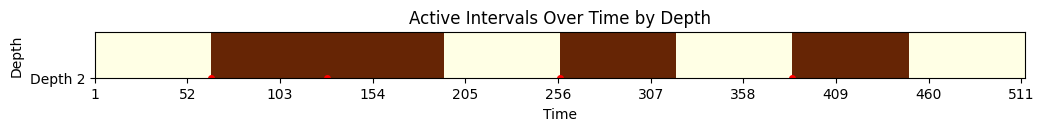

In [330]:
T = 2500
env = Environment.Environment(T, 3)
algo = Policy.MBDE(T)

algo.initialize_episode()
algo.initialize_block()
#algo.tree.activate_depth(2) # TODO: change
algo.tree.update_proba()
#algo.tree.visualize_tree()

algo.tree.visualize()
sim = Simulator(algo, env, T)


evicted with interval [47, 417]
Node (3, 1) evicted at t=417 (Replay(2))
Entering Block 4


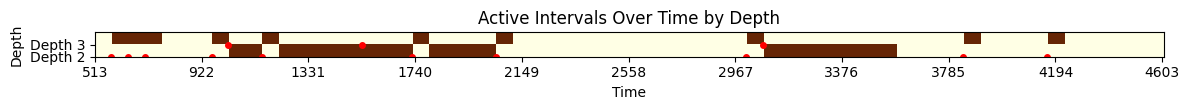

evicted with interval [542, 544]
Node (4, 1) evicted at t=544 (Replay(4))
evicted with interval [542, 544]
Node (4, 2) evicted at t=544 (Replay(4))
evicted with interval [542, 544]
Node (4, 3) evicted at t=544 (Replay(4))
evicted with interval [542, 544]
Node (4, 4) evicted at t=544 (Replay(4))
evicted with interval [542, 544]
Node (4, 5) evicted at t=544 (Replay(4))
evicted with interval [542, 544]
Node (4, 6) evicted at t=544 (Replay(4))
evicted with interval [542, 544]
Node (4, 7) evicted at t=544 (Replay(4))
evicted with interval [643, 646]
Node (4, 1) evicted at t=646 (Replay(2))
evicted with interval [642, 646]
Node (4, 2) evicted at t=646 (Replay(2))
evicted with interval [642, 646]
Node (4, 3) evicted at t=646 (Replay(2))
evicted with interval [642, 646]
Node (4, 4) evicted at t=646 (Replay(2))
evicted with interval [642, 646]
Node (4, 5) evicted at t=646 (Replay(2))
evicted with interval [642, 646]
Node (4, 6) evicted at t=646 (Replay(2))
evicted with interval [642, 646]
Node 

/Users/nicolasnguyen/Documents/Projets/Non-Stationary Lipschitz Bandits/NS_Lipschitz_Bandits/Policy.py:269: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


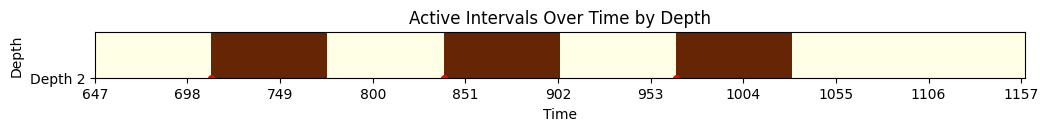

evicted with interval [909, 916]
Node (3, 2) evicted at t=916 (Replay(3))
evicted with interval [909, 916]
Node (3, 3) evicted at t=916 (Replay(3))
Entering Block 4


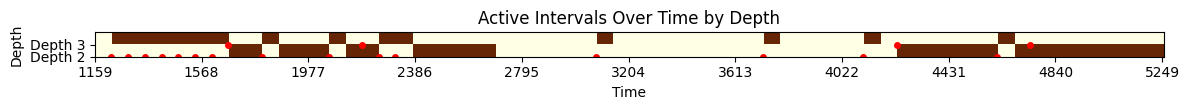

evicted with interval [1167, 1169]
Node (4, 1) evicted at t=1169 (Replay(4))
evicted with interval [1167, 1169]
Node (4, 2) evicted at t=1169 (Replay(4))
evicted with interval [1167, 1169]
Node (4, 3) evicted at t=1169 (Replay(4))
evicted with interval [1167, 1169]
Node (4, 4) evicted at t=1169 (Replay(4))
evicted with interval [1167, 1169]
Node (4, 5) evicted at t=1169 (Replay(4))
evicted with interval [1167, 1169]
Node (4, 6) evicted at t=1169 (Replay(4))
evicted with interval [1167, 1169]
Node (4, 7) evicted at t=1169 (Replay(4))
evicted with interval [1925, 1928]
Node (4, 1) evicted at t=1928 (Replay(2))
evicted with interval [1925, 1928]
Node (4, 3) evicted at t=1928 (Replay(2))
evicted with interval [1925, 1928]
Node (4, 4) evicted at t=1928 (Replay(2))
evicted with interval [1925, 1928]
Node (4, 5) evicted at t=1928 (Replay(2))
evicted with interval [1925, 1928]
Node (4, 6) evicted at t=1928 (Replay(2))
evicted with interval [1925, 1928]
Node (4, 7) evicted at t=1928 (Replay(2))

/Users/nicolasnguyen/Documents/Projets/Non-Stationary Lipschitz Bandits/NS_Lipschitz_Bandits/Policy.py:269: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


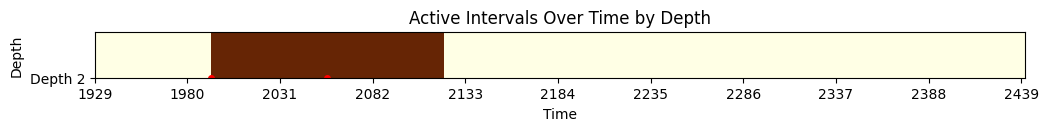

evicted with interval [1979, 2063]
Node (3, 4) evicted at t=2063 (Replay(3))
Entering Block 4


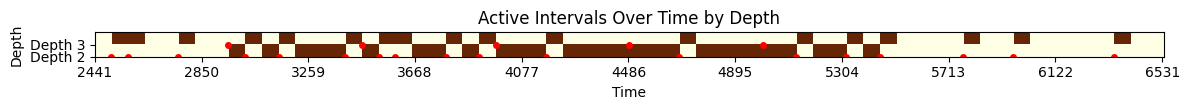

evicted with interval [2476, 2478]
Node (4, 2) evicted at t=2478 (Replay(4))
evicted with interval [2476, 2478]
Node (4, 3) evicted at t=2478 (Replay(4))
evicted with interval [2476, 2478]
Node (4, 4) evicted at t=2478 (Replay(4))
evicted with interval [2476, 2478]
Node (4, 5) evicted at t=2478 (Replay(4))
evicted with interval [2476, 2478]
Node (4, 6) evicted at t=2478 (Replay(4))
evicted with interval [2476, 2478]
Node (4, 7) evicted at t=2478 (Replay(4))
evicted with interval [2476, 2478]
Node (4, 8) evicted at t=2478 (Replay(4))


In [331]:
sim.run()

In [320]:
sim.algo.StoreActive

defaultdict(dict,
            {4: {'starting': 513, 'ending': 4609},
             2: {'starting': 1856, 'ending': 1920},
             3: {'starting': 1536, 'ending': 2048}})

In [321]:
sim.algo.tree.active_depths

{4: [(4,4), (4,3), (4,6), (4,2), (4,5), (4,8), (4,1), (4,7)]}

In [322]:
sim.algo.B_MASTER

[(4,4), (4,3), (4,6), (4,2), (4,5), (4,8), (4,1), (4,7)]

In [323]:
sim.algo.tree.visualize()